In [1]:
import os
import pandas as pd
import string
from datetime import datetime
from os import path
import json
import numpy as np
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open(path.expanduser("~") + "/sys_specific.json") as file: 
    params = json.load(file)
_HOME_ = params["home"] + "/PHD"

In [3]:
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [51]:
df_chem_phys = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data.csv")

In [52]:
df_chem_phys["id"] = pd.Categorical(df_chem_phys["id"], categories=ordered_id, ordered=True)
df_chem_phys["Region"] = pd.Categorical(df_chem_phys["Region"], categories=ordered_regions, ordered=True)
df_chem_phys["Date"] = pd.to_datetime(df_chem_phys["Date"])
df_chem_phys["SampleDepth"] = df_chem_phys["SampleDepth"].astype("float")

In [53]:
depth_threshold = 2

In [54]:
simplified_chem_phys = df_chem_phys.query("SampleDepth <= @depth_threshold")

In [55]:
simplified_chem_phys = simplified_chem_phys.loc[~simplified_chem_phys["QF"].isin(["3", "4"]), :]

In [57]:
simplified_chem_phys.loc[:, "SampleDepth"] = simplified_chem_phys.loc[:, "SampleDepth"].apply(lambda x: round(x * 2) / 2)

In [ ]:
nutrients = df_chem_phys["Nutrient"].unique()

In [66]:
simplified_chem_phys = dict([(nut, simplified_chem_phys.query("Nutrient == @nut")) for nut in nutrients])

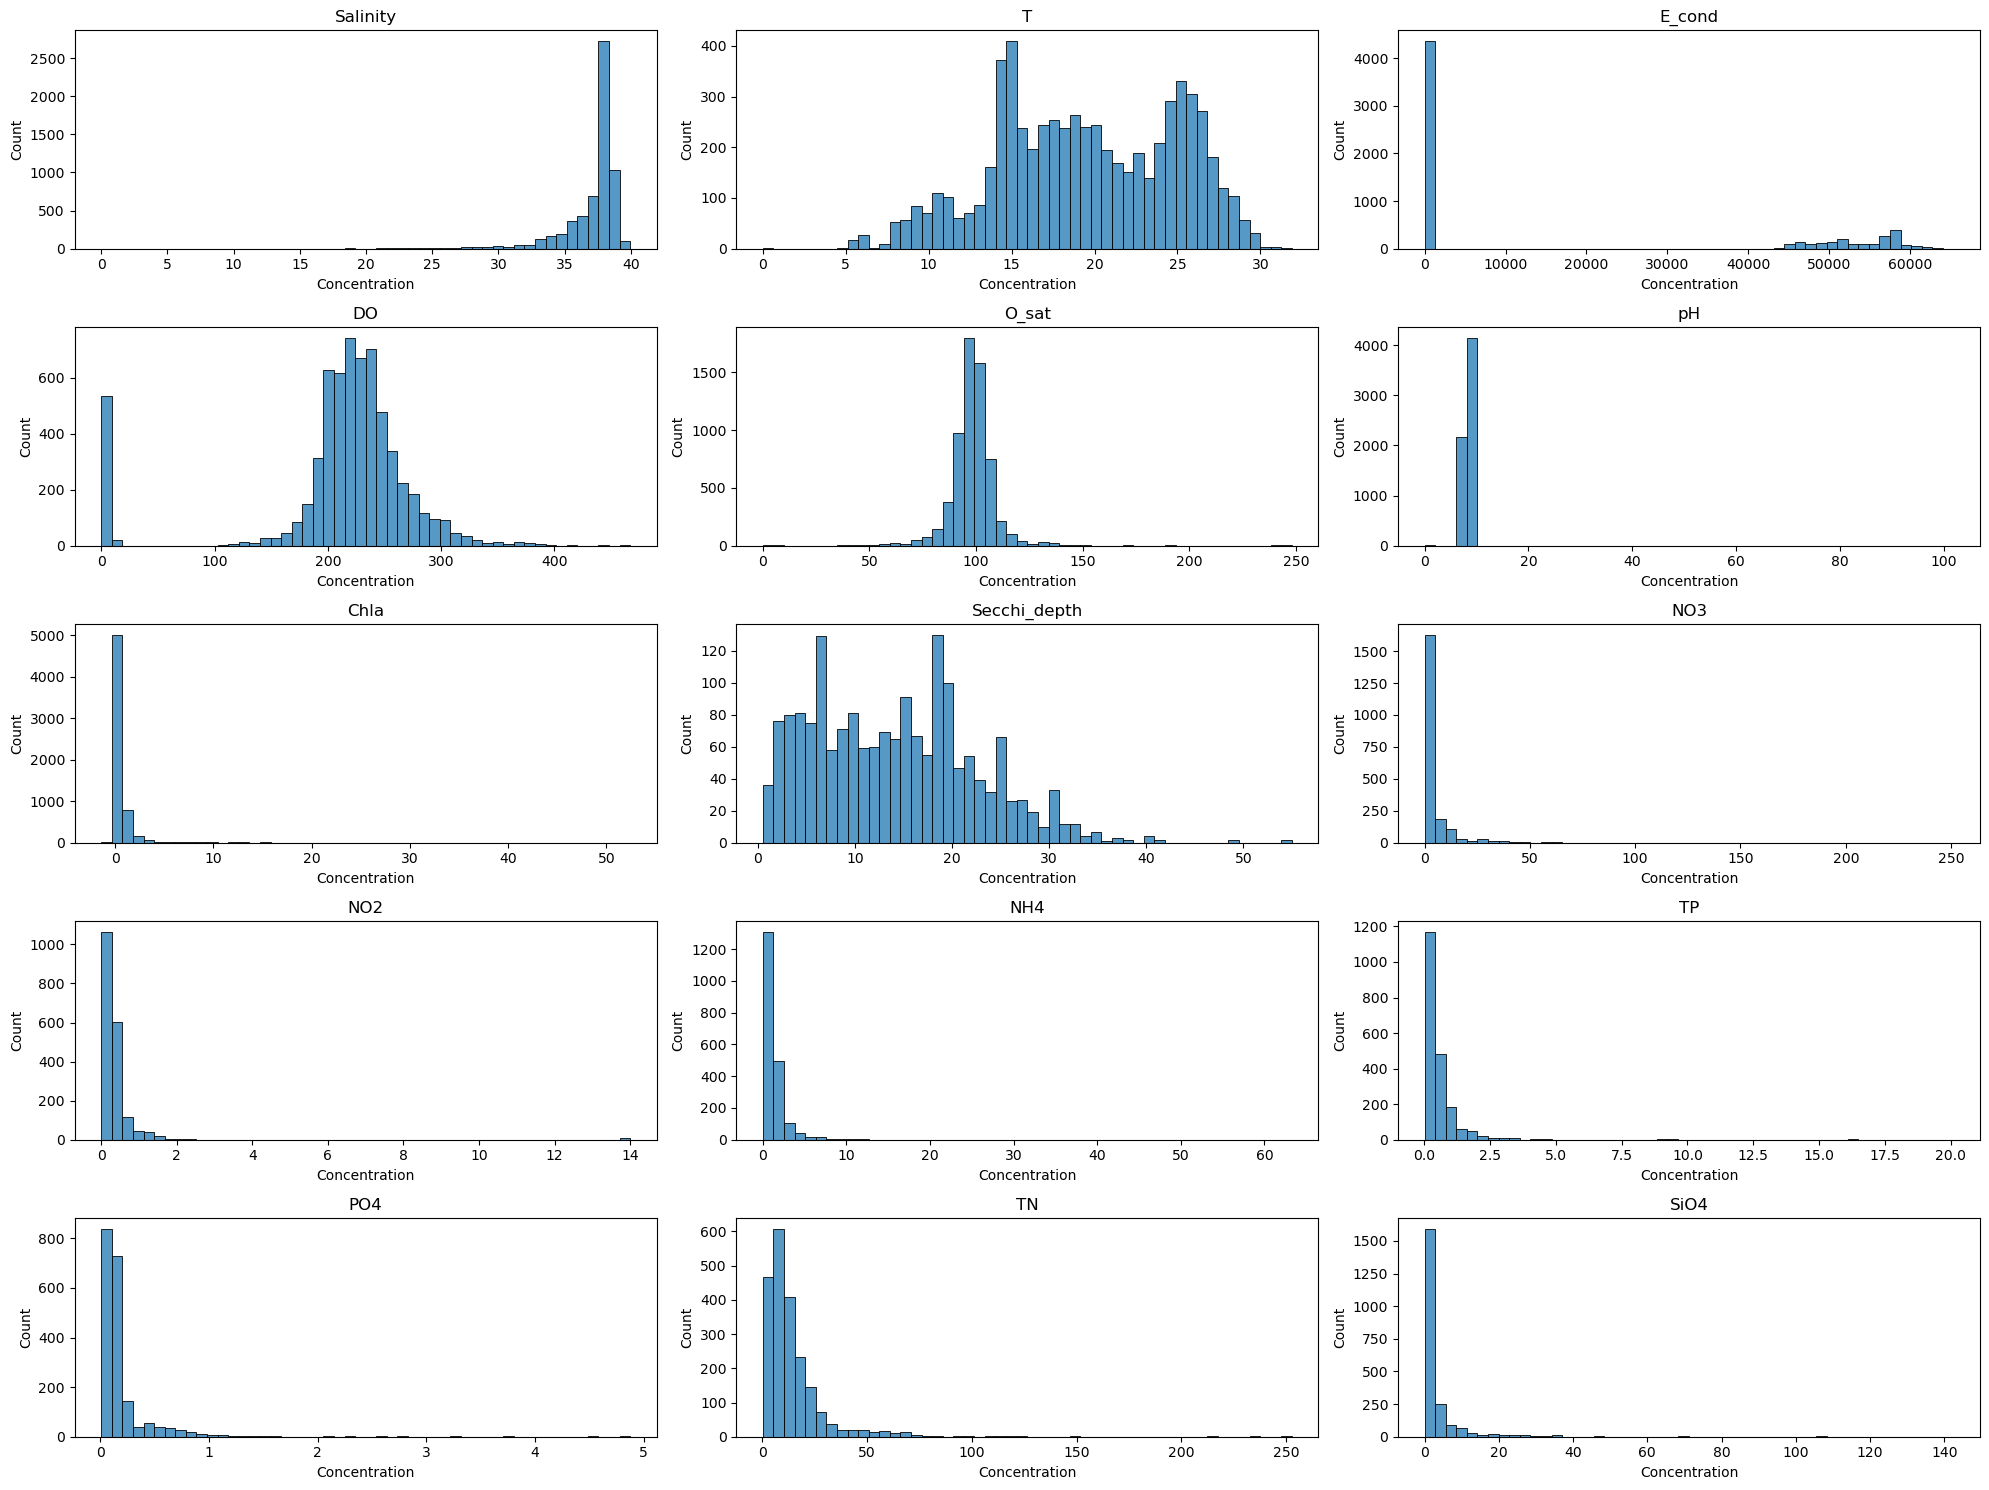

In [68]:
fig, axs = plt.subplots(5, 3, figsize=(20, 15))
axs = axs.ravel()
for (nut, ax) in zip(nutrients, axs):
    df_nut = simplified_chem_phys[nut]
    sns.histplot(data=df_nut, x="Concentration", ax=ax, bins=50)
    ax.set_title(nut)
plt.tight_layout()

In [69]:
expression = "Concentration > 2.5"
nut = "T"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [70]:
expression = "Concentration > 25 and Concentration < 200"
nut = "O_sat"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [71]:
expression = "Concentration <= 10 and Concentration >= 4"
nut = "pH"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [72]:
expression = "Concentration <= 20 and Concentration >0"
nut = "Chla"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [73]:
expression = "Concentration <= 100"
nut = "NO3"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [74]:
expression = "Concentration <= 3"
nut = "PO4"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [75]:
expression = "Concentration <= 20"
nut = "NH4"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [76]:
expression = "Concentration <= 5"
nut = "TP"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [77]:
expression = "Concentration <= 150"
nut = "TN"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [78]:
expression = "Concentration <= 60"
nut = "SiO4"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [103]:
expression = "Concentration <= 6"
nut = "NO2"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [80]:
expression = "Concentration >= 100"
nut = "DO"
simplified_chem_phys[nut].loc[:, "Concentration"] = simplified_chem_phys[nut].loc[:, "Concentration"].apply(lambda x: x * 0.0821 * 298.15 if x < 100 else x)
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [92]:
expression = "Concentration >= 15"
nut = "Salinity"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

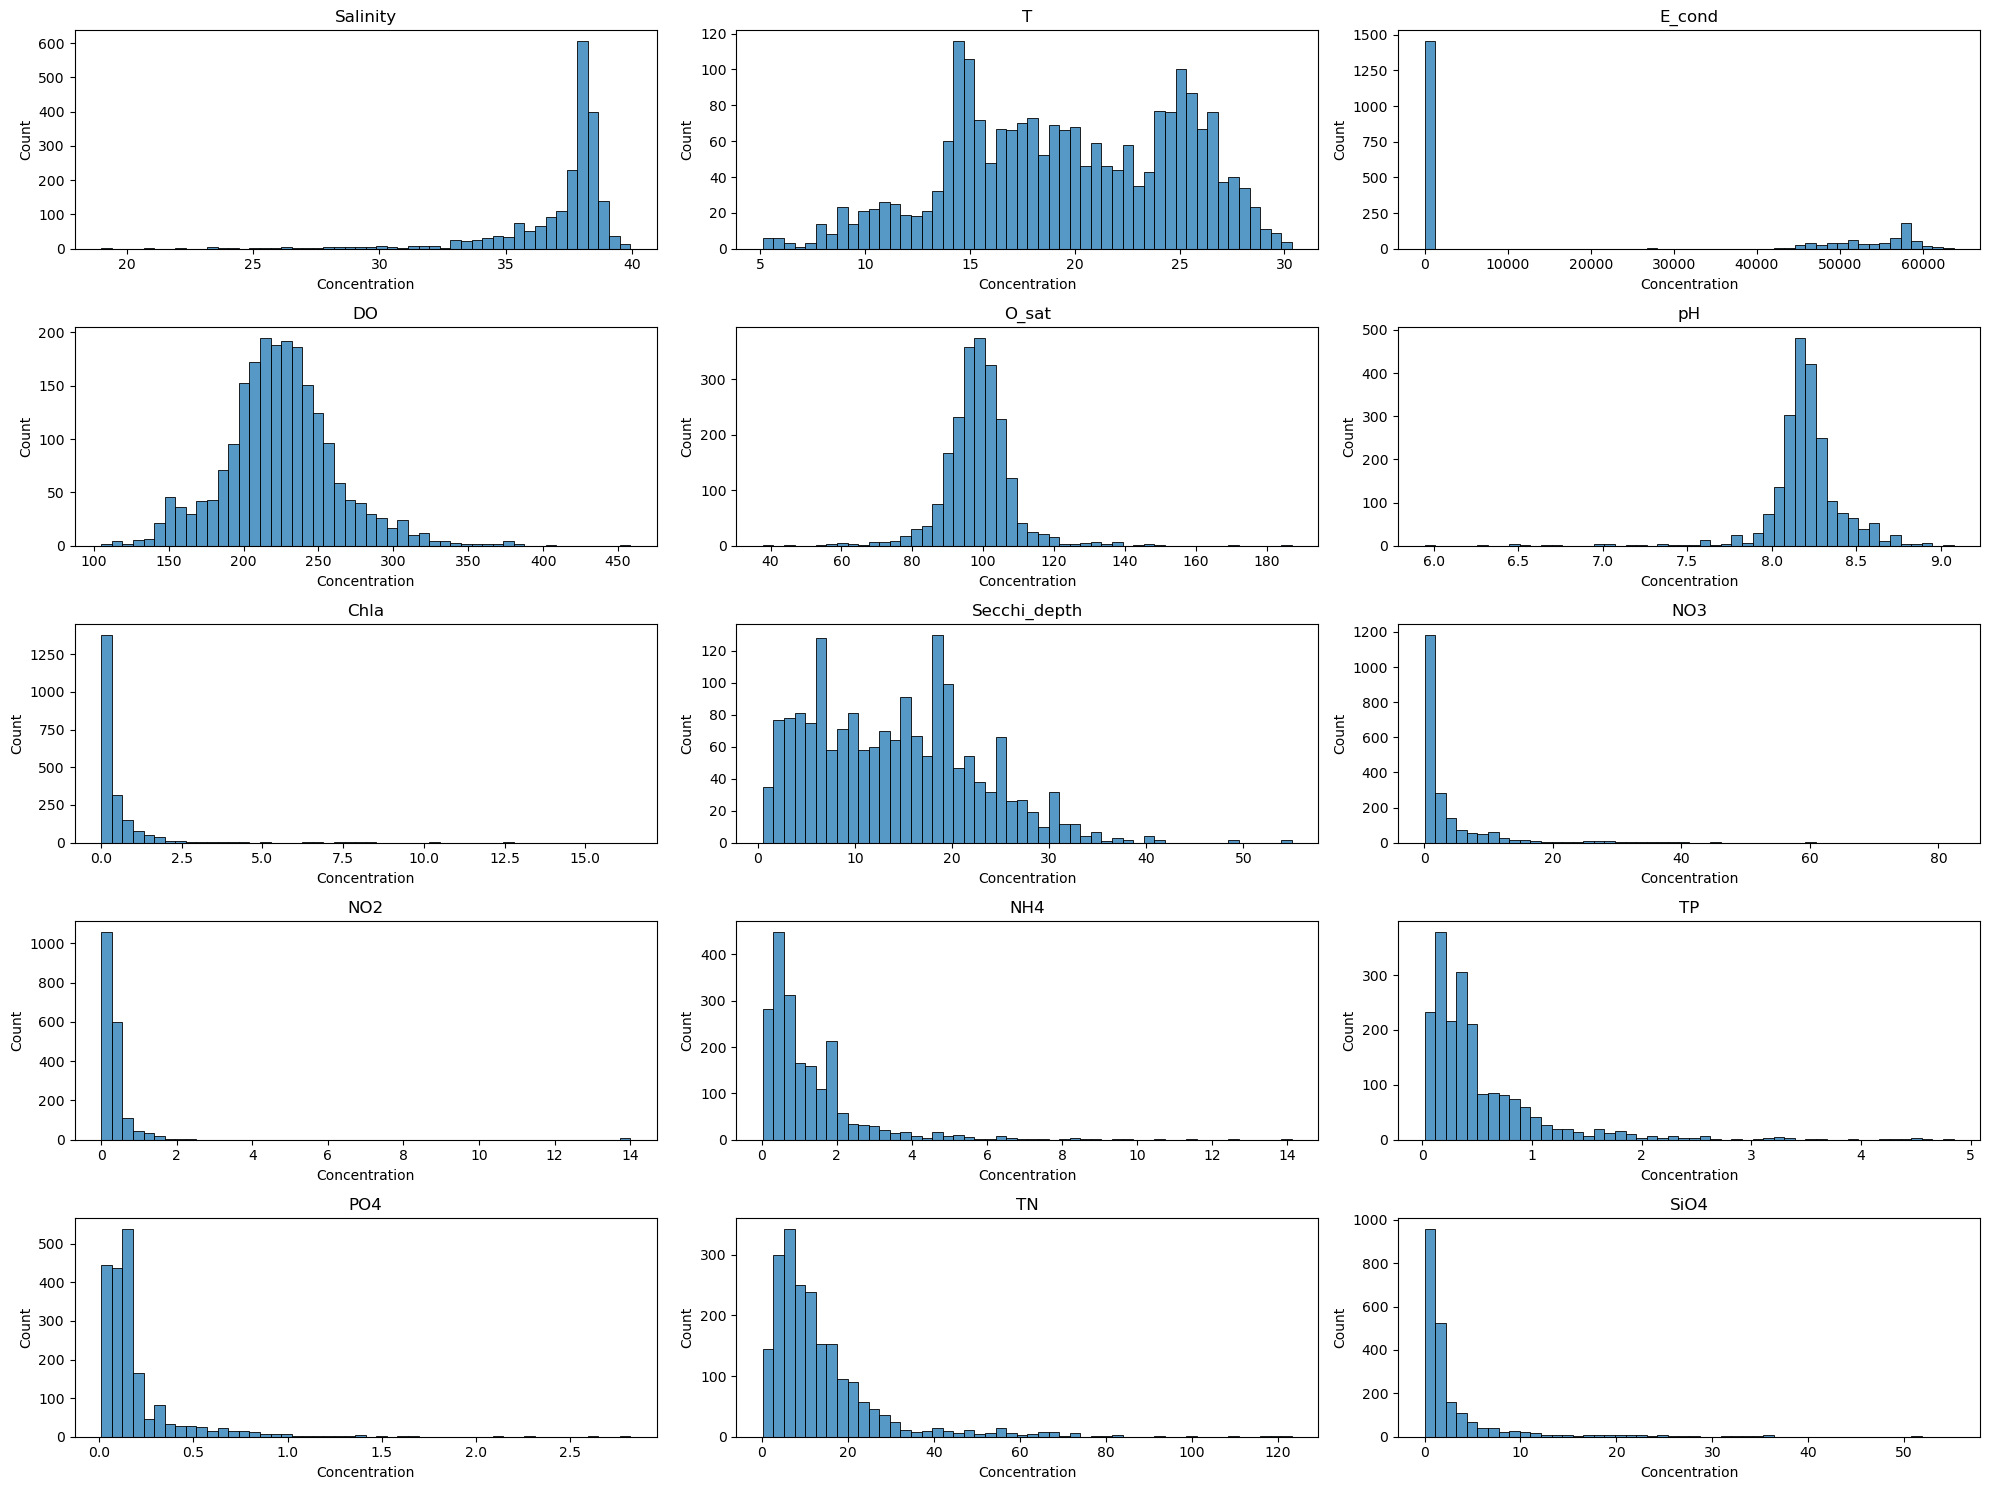

In [93]:
fig, axs = plt.subplots(5, 3, figsize=(20, 15))
axs = axs.ravel()
for ((nut, df_nut), ax) in zip(simplified_chem_phys.items(), axs):
    sns.histplot(data=df_nut.groupby(["id", "Date"], observed = True).mean(numeric_only = True), x="Concentration", ax=ax, bins=50)
    ax.set_title(nut)
plt.tight_layout()

In [82]:
N = len(simplified_chem_phys.keys())
min = np.zeros(N)
max = np.zeros(N)
nut_index = np.empty(N, dtype = "<U10")
for k, (nut, df_nut) in enumerate(simplified_chem_phys.items()):
    nut_index[k] = nut
    Q1 = df_nut["Concentration"].quantile(0.25)
    Q3 = df_nut["Concentration"].quantile(0.75)
    IQR = Q3 - Q1
    min[k] = Q1 - 1.5 * IQR
    max[k] = Q3 + 1.5 * IQR
outliers_df = pd.DataFrame(
    data = {
        "min" : min, 
        "max" : max
    }, 
    index = nut_index
)
outliers_df[outliers_df <= 0] = 0
outliers_df

,min,max
Salinity,34.377925,40.570125
T,1.108250,38.456650
E_cond,0.000000,122355.192525
DO,139.519775,308.300375
O_sat,80.150000,116.550000
pH,7.871000,8.535000
Chla,0.000000,1.175000
Secchi_dep,0.000000,39.500000
NO3,0.000000,8.920000
NO2,0.000000,0.727500


"<" quantiticabilità
"]" rilevabilità

In [111]:
for nut in nutrients: 
    print(nut, simplified_chem_phys[nut]["QF"].unique())

Salinity [nan '1']
T [nan '1']
E_cond [nan]
DO [nan '1']
O_sat [nan '<']
pH [nan]
Chla [nan '1' '<' 'Q']
Secchi_depth [nan '1']
NO3 [nan '1' 'Q' '<' '[' '6' '< ']
NO2 [nan '1' 'Q' '[' '<' '6' '< ']
NH4 [nan '1' 'Q' '<' '[' '6' '< ']
TP [nan '1' 'Q' '[' '6' '<' '< ']
PO4 [nan '1' 'Q' '[' '<' '6' '< ']
TN [nan '1' '[' 'Q' '<' '6']
SiO4 [nan '1' 'Q' '<' '[' '6']


In [125]:
for nut in ["Chla", "NO3", "NO2", "NH4", "TP", "PO4", "TN", "SiO4"]: 
    # set to zero concentrations below level of detectability
    simplified_chem_phys[nut].loc[simplified_chem_phys[nut]["QF"].isin(["6", "["]), "Concentration"] = 0
    # set to randon number values below level of quantification
    selection = simplified_chem_phys[nut]["QF"].isin(["<", "Q"])
    simplified_chem_phys[nut].loc[selection, "Concentration"] = simplified_chem_phys[nut].loc[selection, "Concentration"].apply(lambda x: np.random.uniform(0, x))

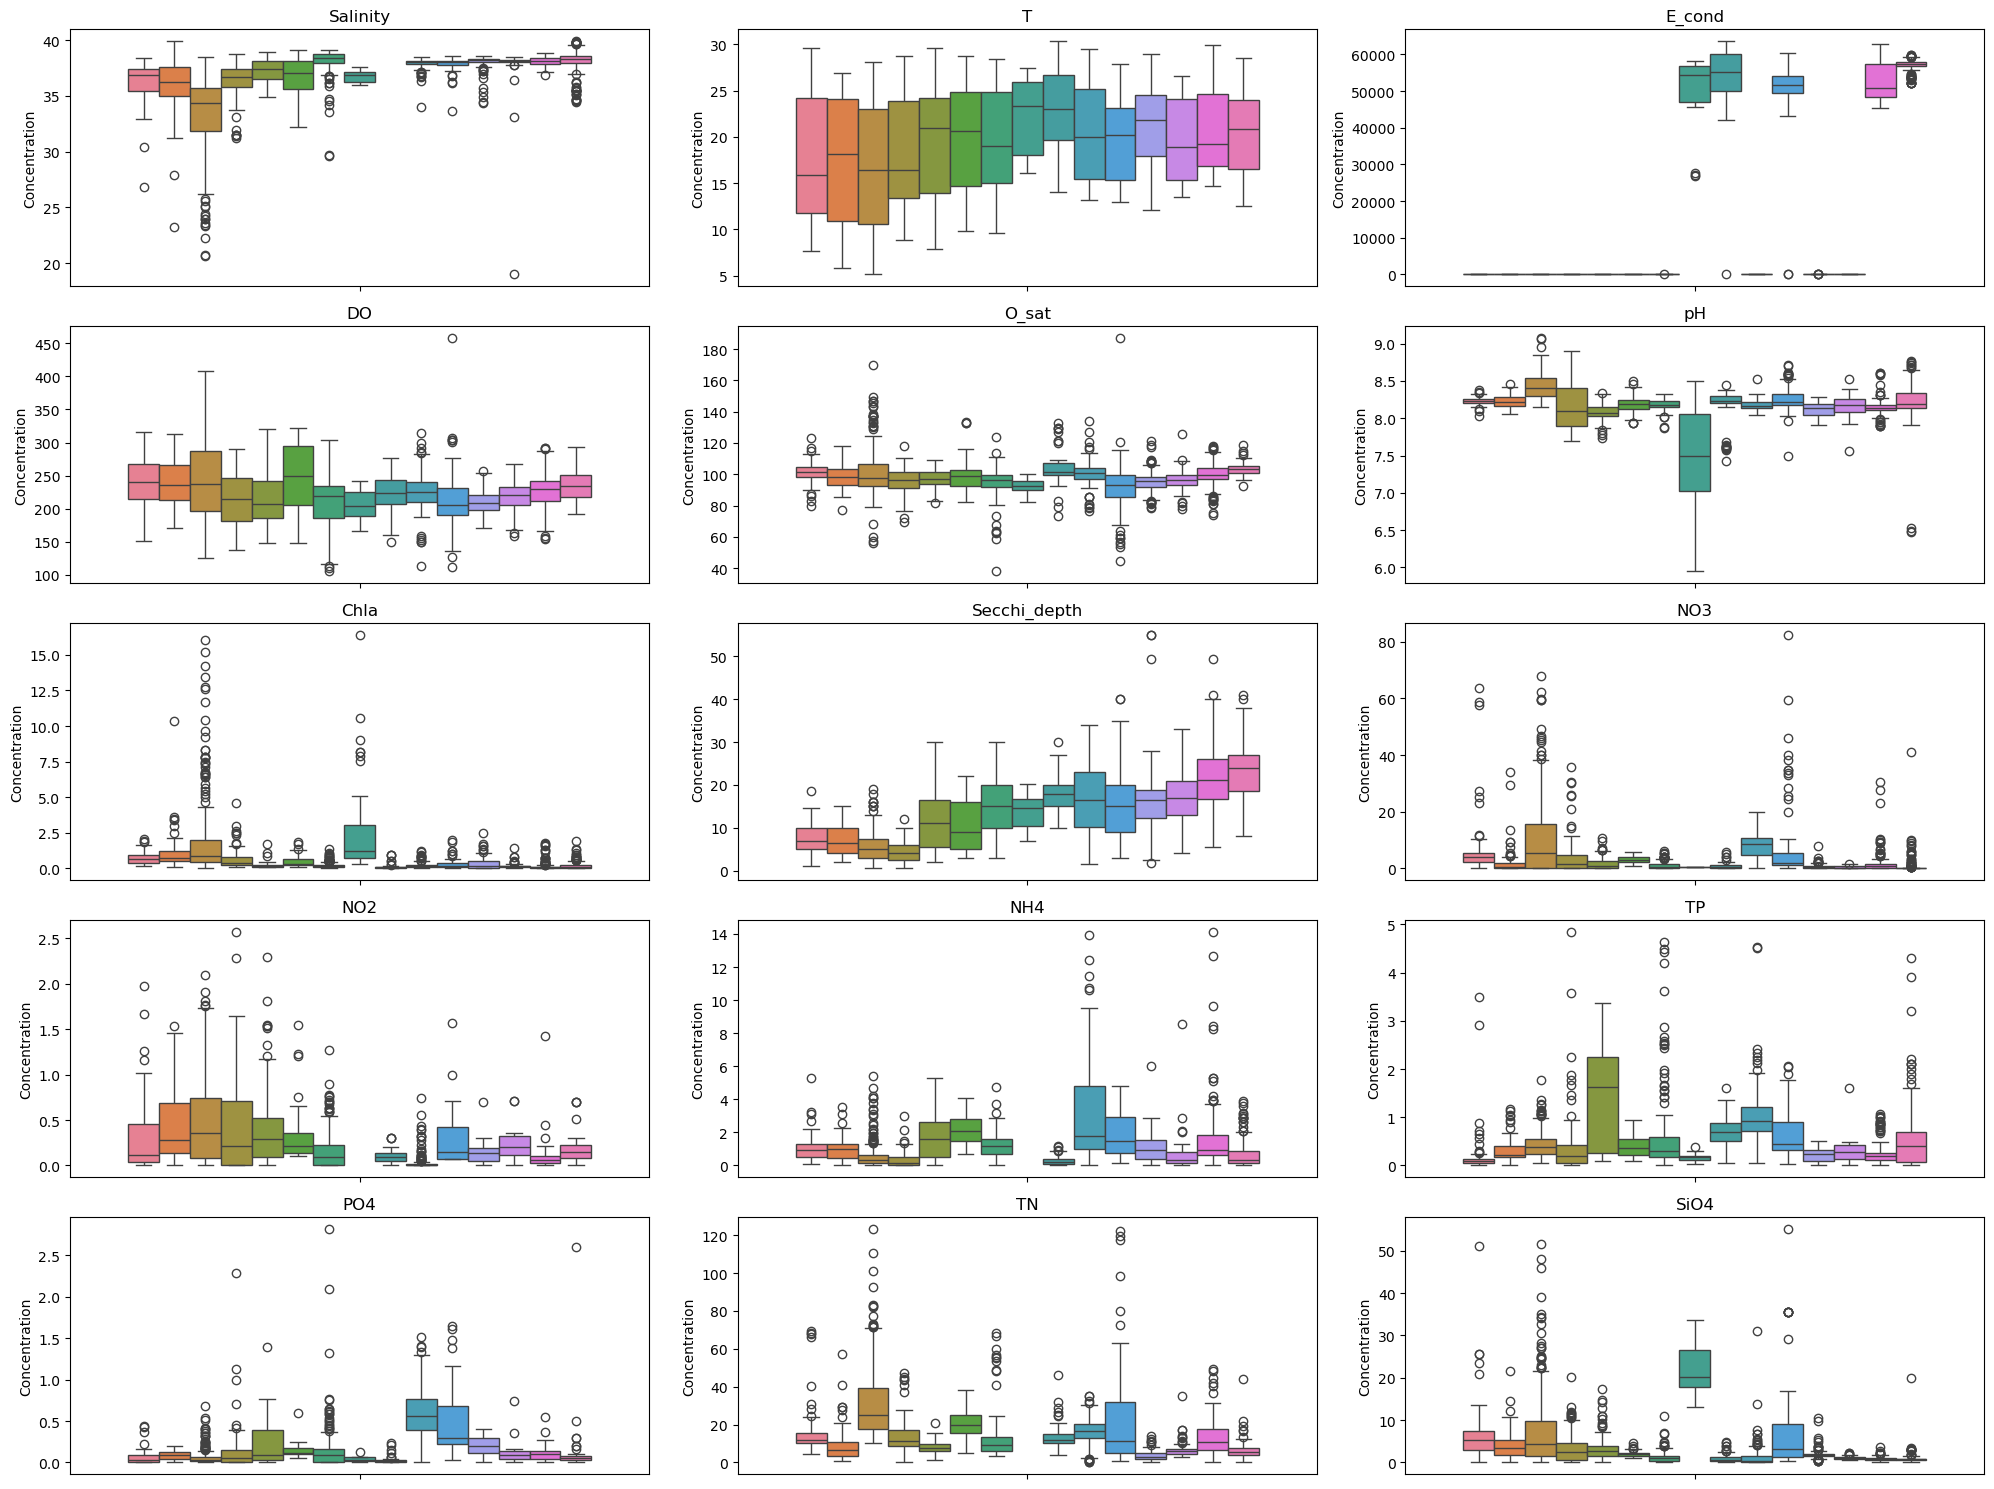

In [126]:
fig, axs = plt.subplots(5, 3, figsize=(20, 15))
axs = axs.ravel()
for ((nut, df_nut), ax) in zip(simplified_chem_phys.items(), axs):
    sns.boxplot(
        data=df_nut.groupby(["id", "Date"], observed = True).agg({"Concentration" : "mean", "Region" : "first"}), 
        y="Concentration", 
        hue = "Region",
        legend = False,
        ax=ax)
    ax.set_title(nut)
plt.tight_layout()

In [ ]:
expression = "Concentration >= 15"
nut = "Salinity"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [127]:
#write data to excel file 
with pd.ExcelWriter(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data_cleaned.xlsx") as writer: 
    for nut in simplified_chem_phys.keys(): 
        simplified_chem_phys[nut].to_excel(writer, sheet_name=nut, index=False)

In [4]:
env_data = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data_cleaned.xlsx", sheet_name=None)
nutrients = list(env_data.keys())

In [6]:
long_format = True
if not long_format: 
    modified_dfs = []

    # Iterate through the dictionary
    for key, df in env_data.items():
        # Rename the 'nutrient' column to the key name
        df_renamed = df.rename(columns={'nutrient': key})
        # Append the modified DataFrame to the list
        modified_dfs.append(df_renamed)
    merged_df = pd.concat(modified_dfs, axis=0)
    merged_df.pivot_table(index=["Region", "id", "Date"], columns="Nutrient", values="Concentration", aggfunc="mean").to_csv(
        _HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data_cleaned_long_format.csv"
    )

0        True
1        True
2        True
3        True
4        True
        ...  
6116    False
6117    False
6118    False
6119    False
6120    False
Name: QF, Length: 6121, dtype: bool

In [42]:
modified_dfs = []
# Iterate through the dictionary
for key, df in env_data.items():
    # Rename the 'nutrient' column to the key name
    df_renamed = df.rename(columns={'nutrient': key})
    only_good = (df_renamed["QF"].isna()) or  
    # Append the modified DataFrame to the list
    modified_dfs.append(df_renamed)
merged_df = pd.concat(modified_dfs, axis=0)
merged_df.pivot_table(index=["Region", "id", "Date"], columns="Nutrient", values=["Concentration", "QF"], aggfunc="mean")

TypeError: agg function failed [how->mean,dtype->object]

In [12]:
env_long = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data_cleaned_long_format.csv")

In [137]:
cluster_index = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Results/cluster_index.csv")

In [144]:
cluster_index["Date"] = pd.to_datetime(cluster_index["Date"])

In [145]:
for nut in nutrients: 
    env_data[nut] = pd.merge(env_data[nut], cluster_index, how = "left")

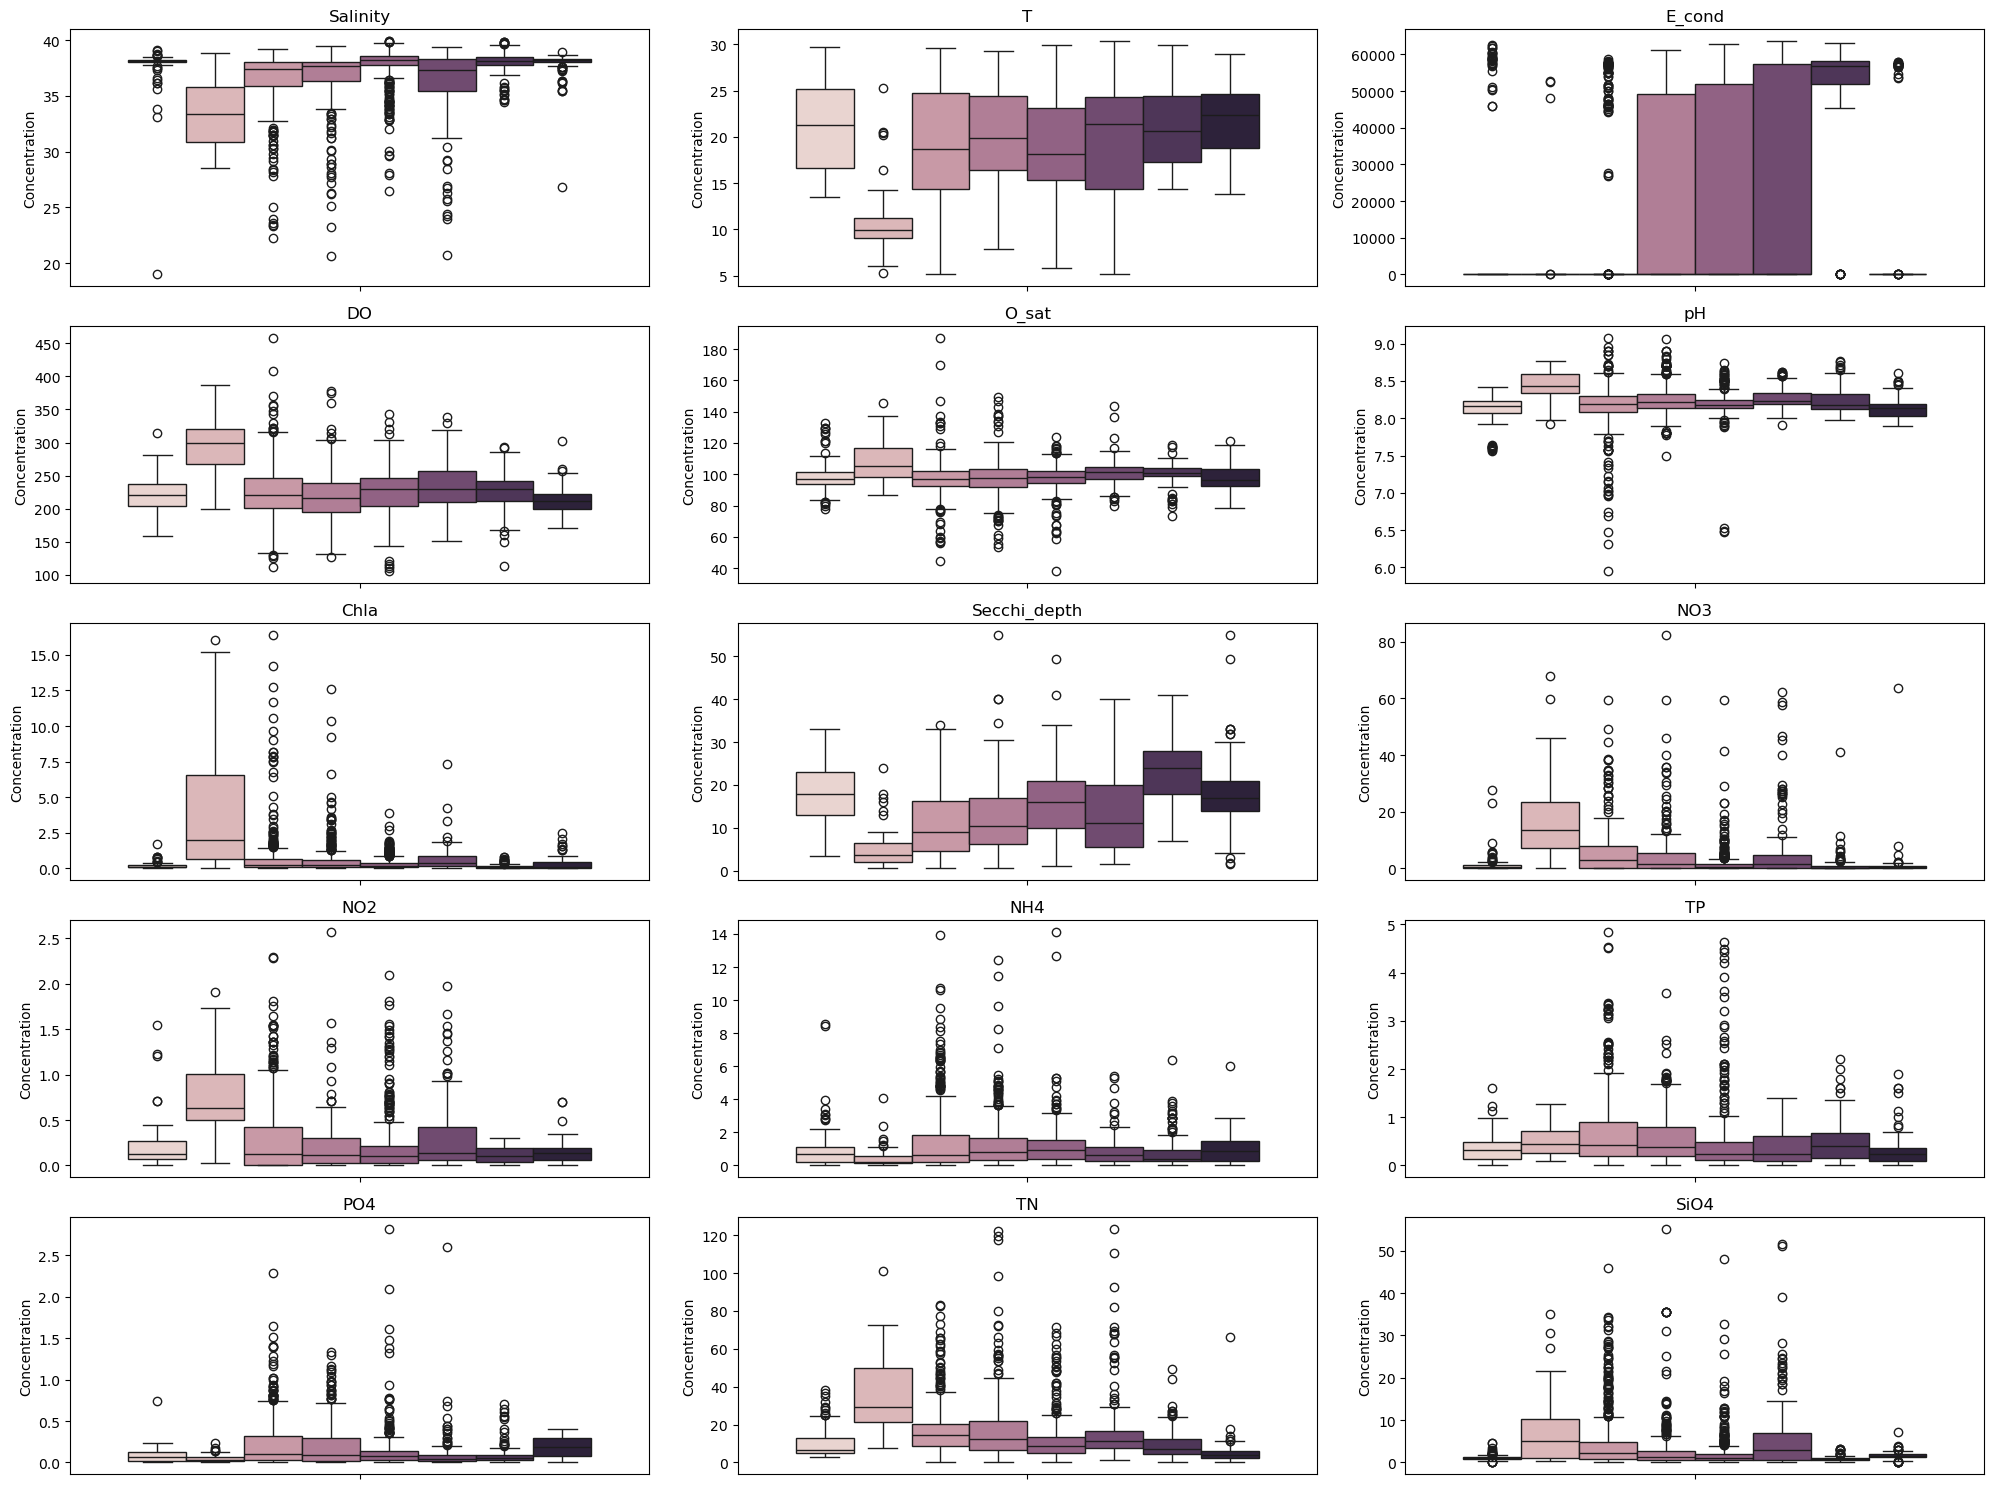

In [149]:
fig, axs = plt.subplots(5, 3, figsize=(20, 15))
axs = axs.ravel()
cluster_method = "ward_8"
for ((nut, df_nut), ax) in zip(env_data.items(), axs):
    sns.boxplot(
        data=df_nut.groupby(["id", "Date"], observed = True).agg({"Concentration" : "mean", cluster_method : "first"}), 
        y="Concentration", 
        hue = cluster_method,
        legend = False,
        ax=ax)
    ax.set_title(nut)
plt.tight_layout()

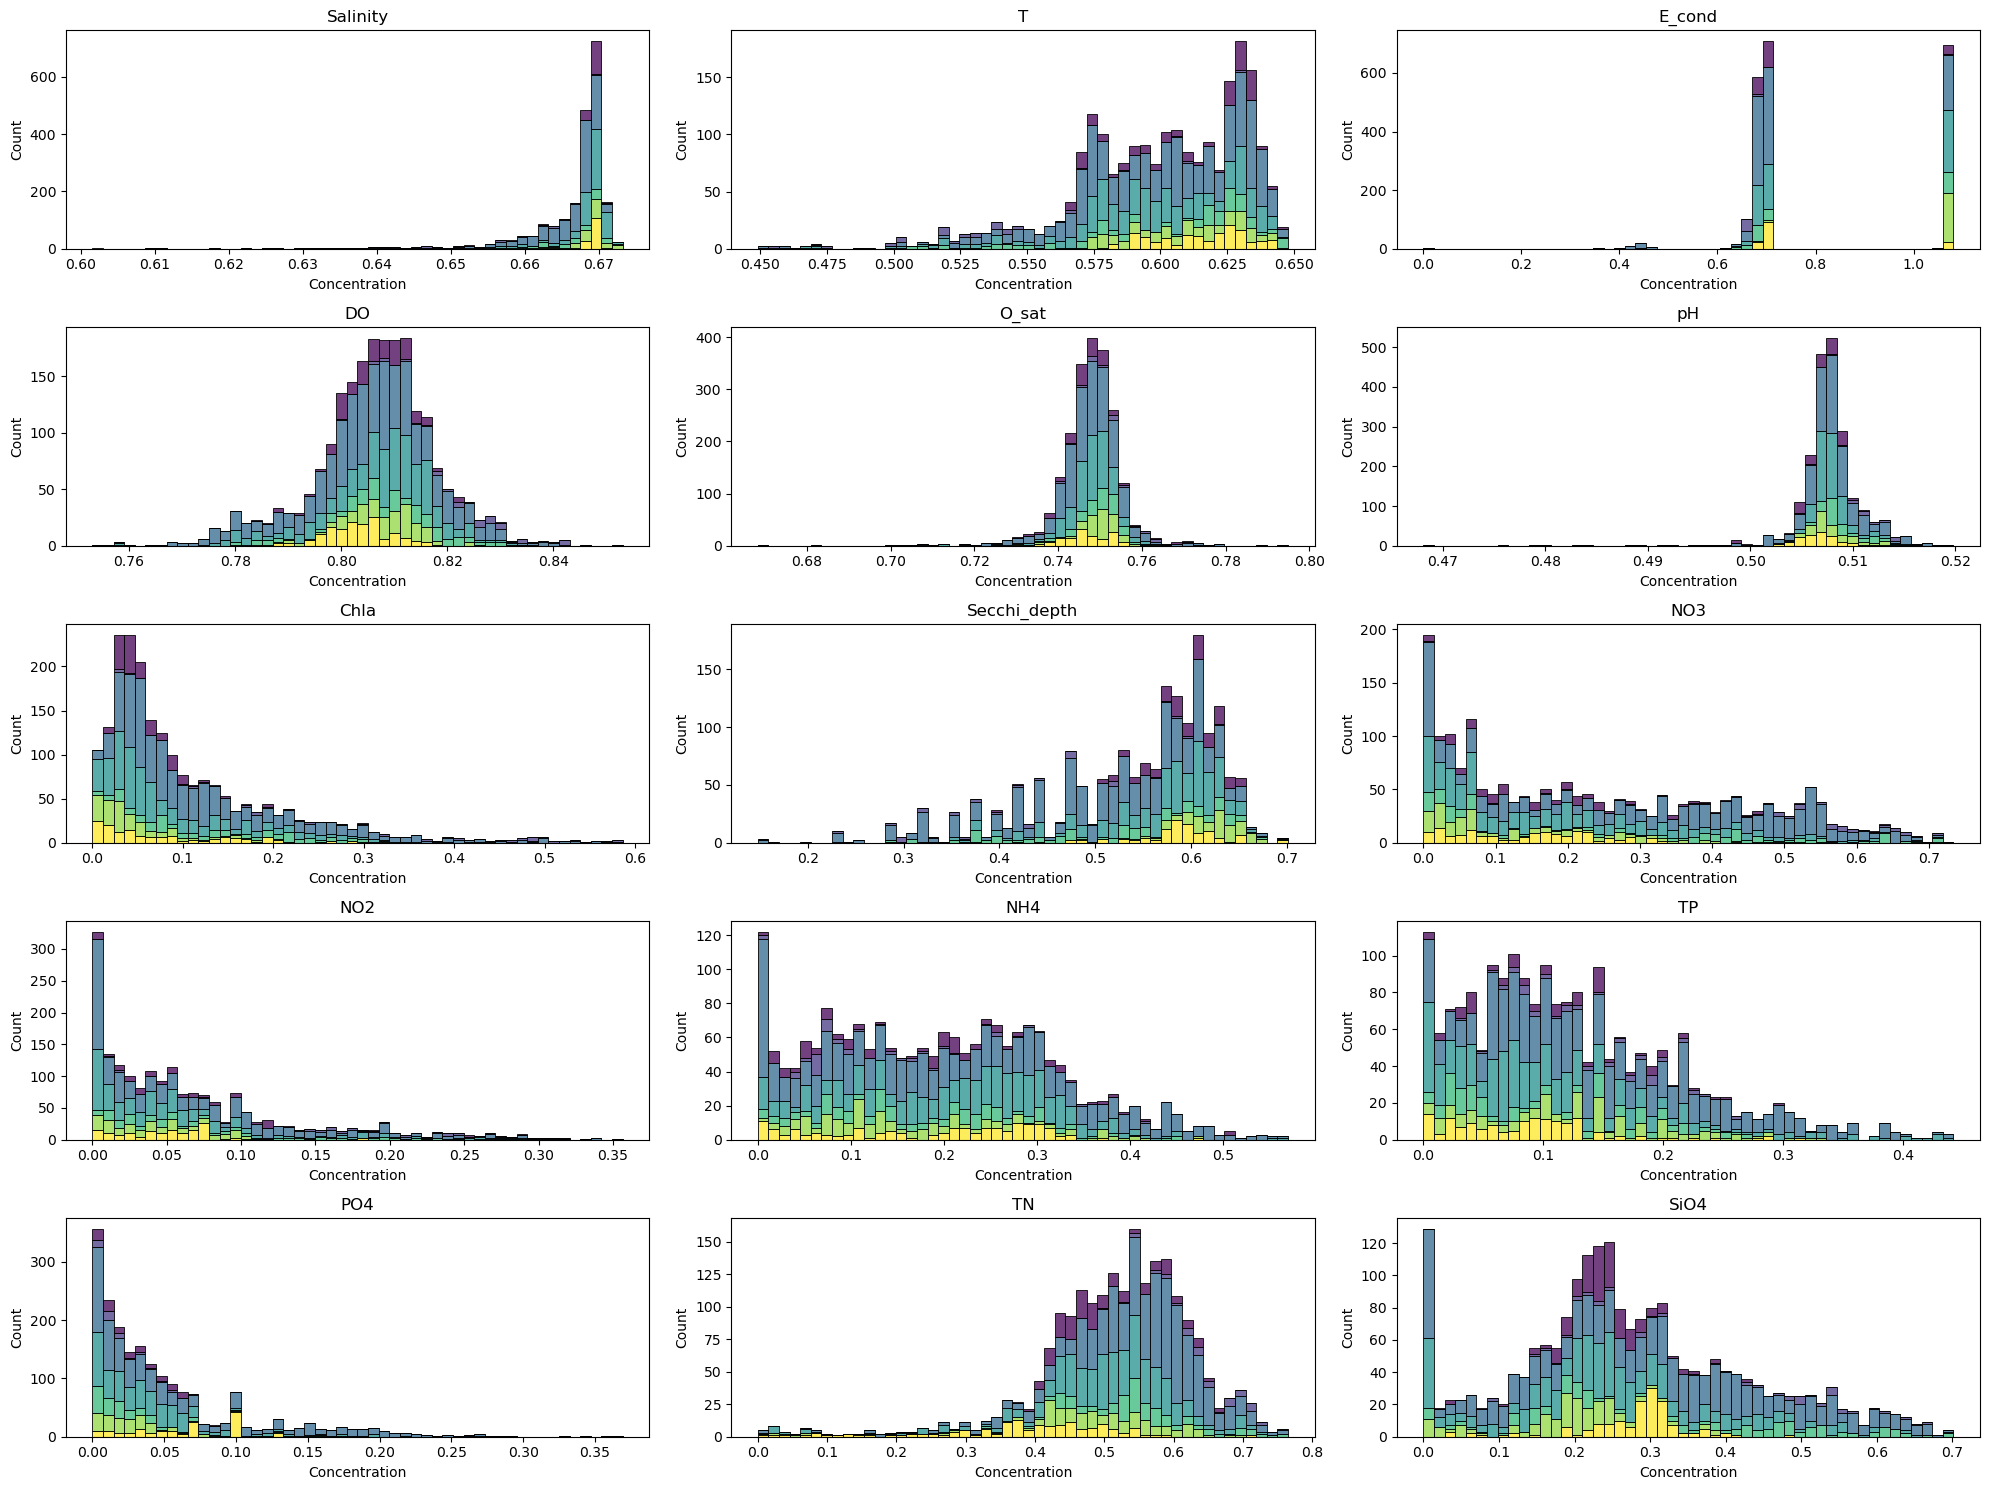

In [157]:
fig, axs = plt.subplots(5, 3, figsize=(20, 15))
axs = axs.ravel()
cluster_method = "ward_7"
for ((nut, df_nut), ax) in zip(env_data.items(), axs):
    df_nut["Concentration"] = df_nut["Concentration"].apply(lambda x: np.log10(x + 1))
    sns.histplot(data=df_nut.groupby(["id", "Date"], observed = True).agg({"Concentration" : "mean", cluster_method : "first"}), 
                 x="Concentration", 
                 ax=ax, 
                 hue = cluster_method, 
                 multiple="stack", 
                 palette="viridis",
                 legend=False,
                 bins=50)
    ax.set_title(nut)
plt.tight_layout()

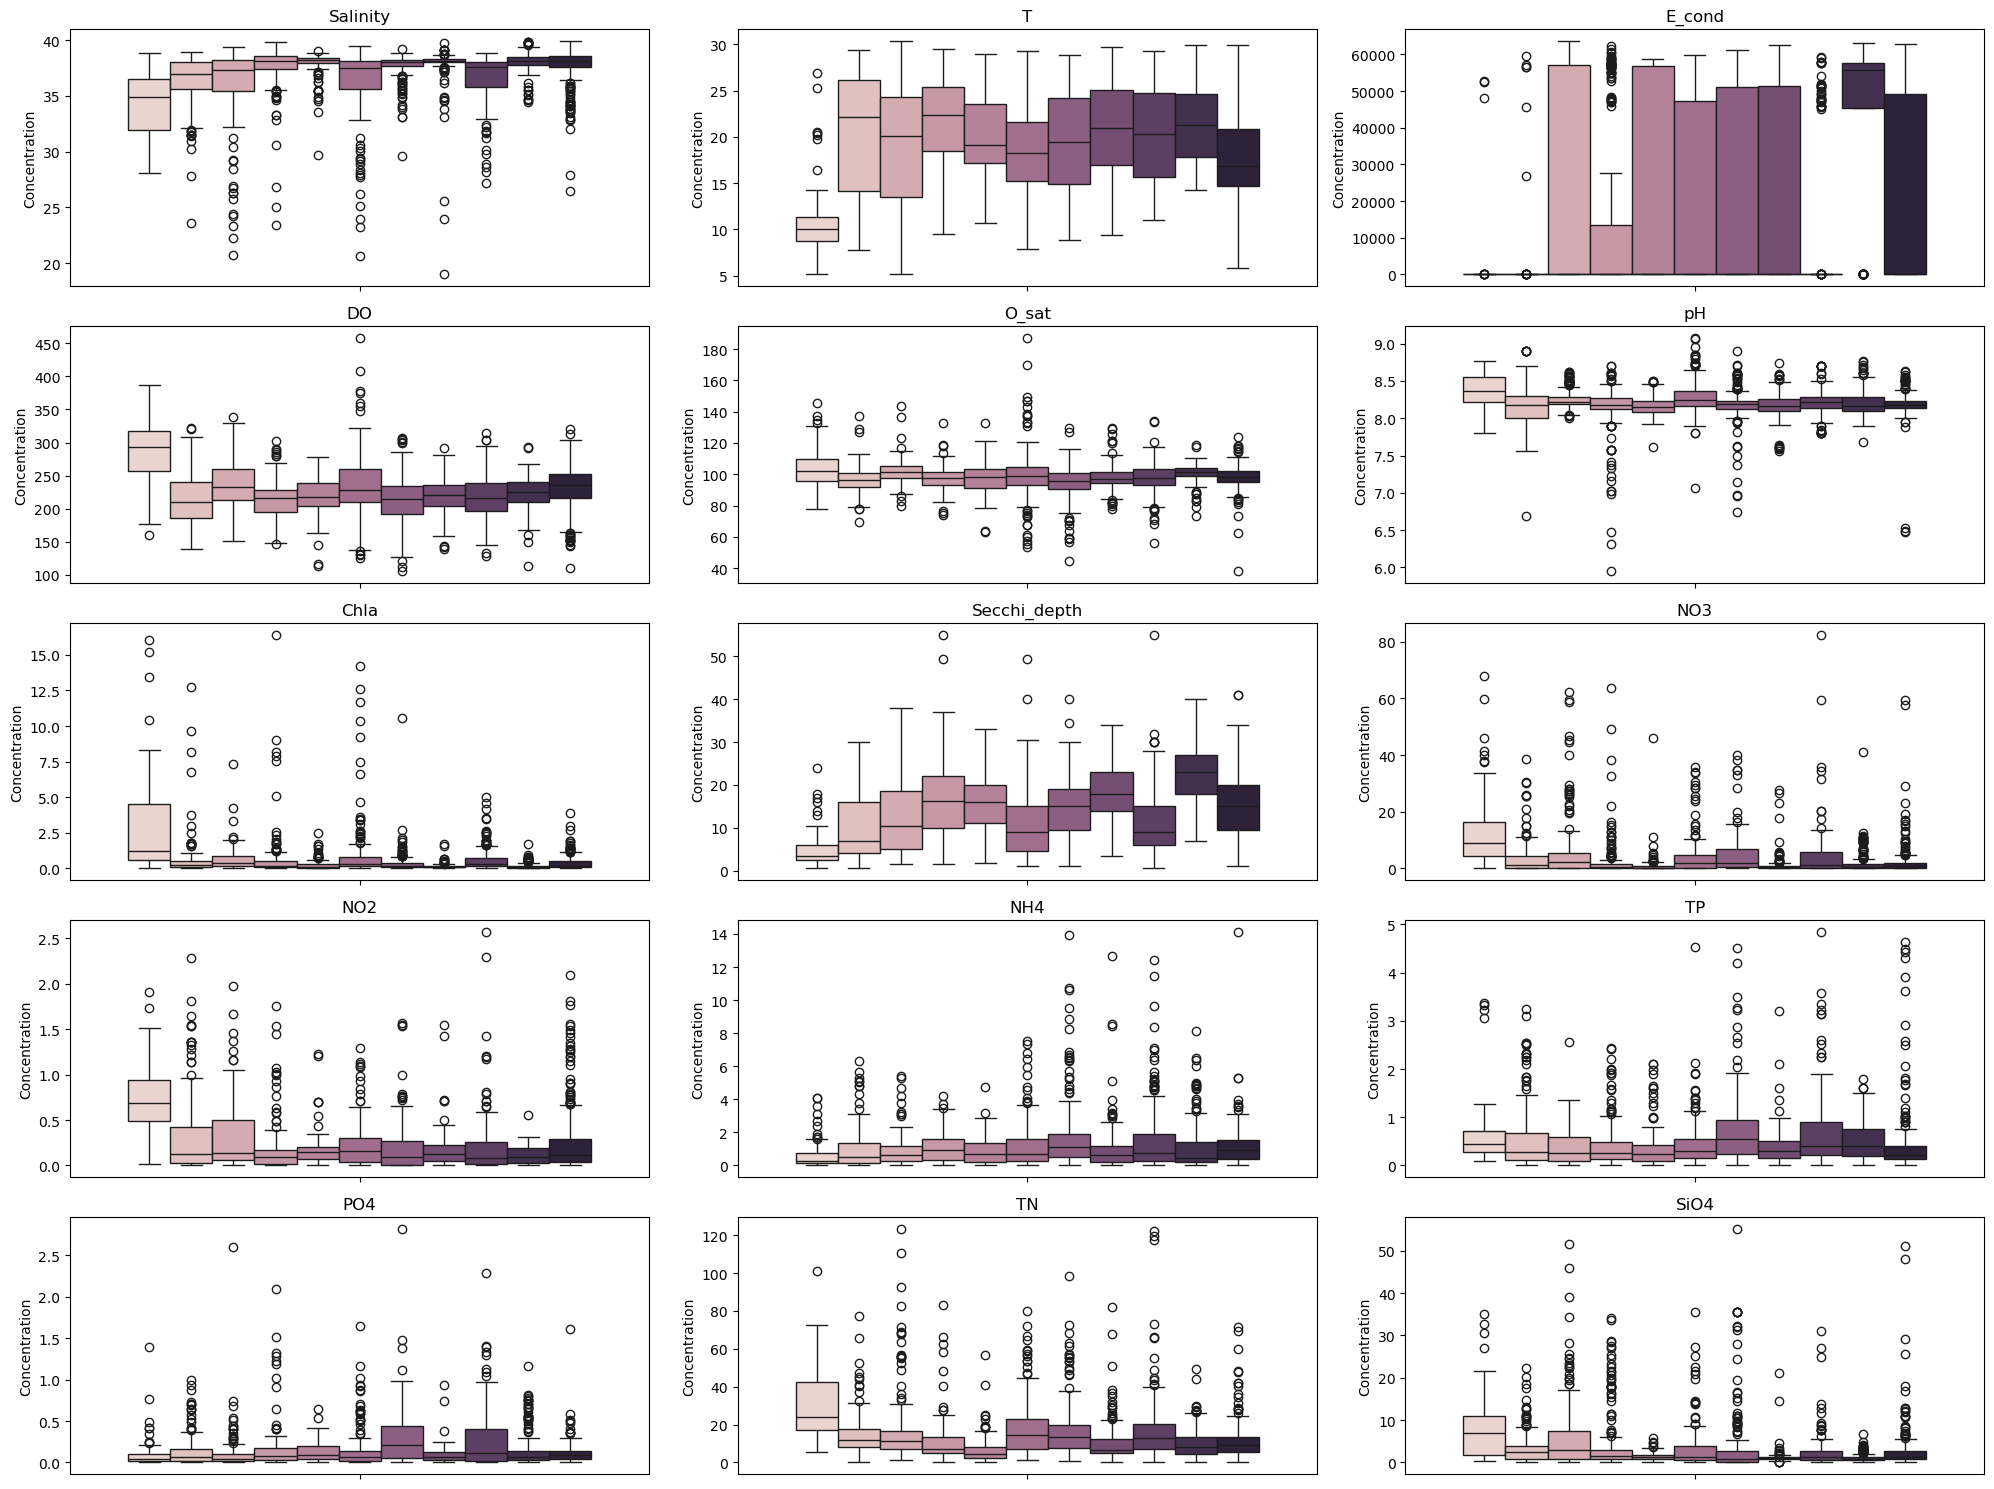

In [155]:
fig, axs = plt.subplots(5, 3, figsize=(20, 15))
axs = axs.ravel()
cluster_method = "spectral_1.5_11"
for ((nut, df_nut), ax) in zip(env_data.items(), axs):
    sns.boxplot(
        data=df_nut.groupby(["id", "Date"], observed = True).agg({"Concentration" : "mean", cluster_method : "first"}), 
        y="Concentration", 
        hue = cluster_method,
        legend = False,
        ax=ax)
    ax.set_title(nut)
    #ax.set_yscale("log")
plt.tight_layout()

In [15]:
env_long.set_index(["Region", "id", "Date"], inplace=True)

In [16]:
env_long.columns

Index(['Chla', 'DO', 'E_cond', 'NH4', 'NO2', 'NO3', 'O_sat', 'PO4', 'Salinity',
       'Secchi_depth', 'SiO4', 'T', 'TN', 'TP', 'pH'],
      dtype='object')

<Axes: >

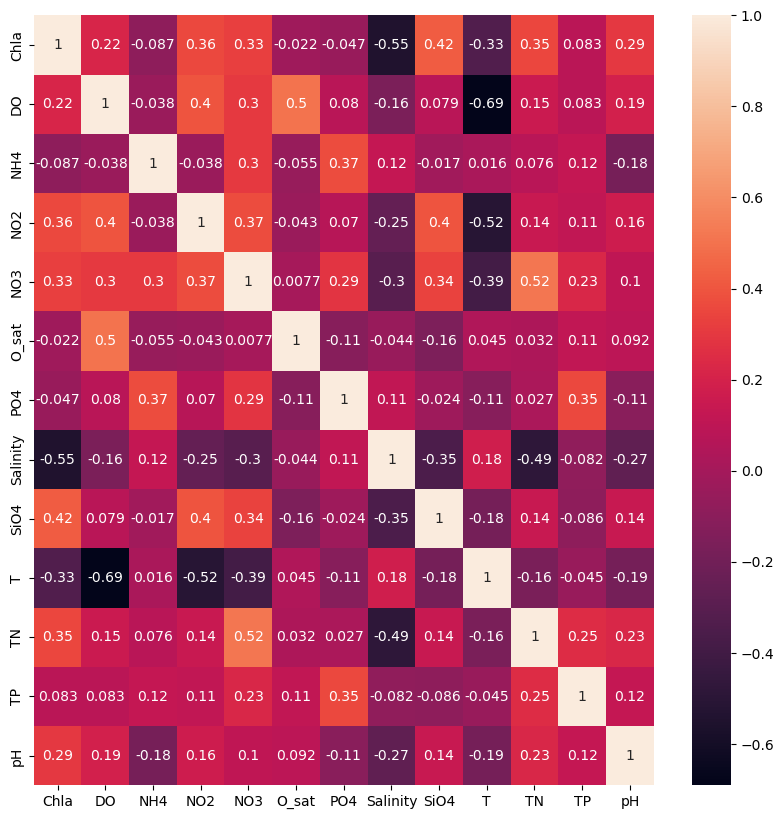

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(env_long.loc[:, 
             ['Chla', 'DO', 'NH4', 'NO2', 'NO3', 'O_sat', 'PO4', 'Salinity', 'SiO4', 'T', 'TN', 'TP', 'pH']
             ].corr(method = "spearman"), 
             ax = ax, 
            annot=True,
             )

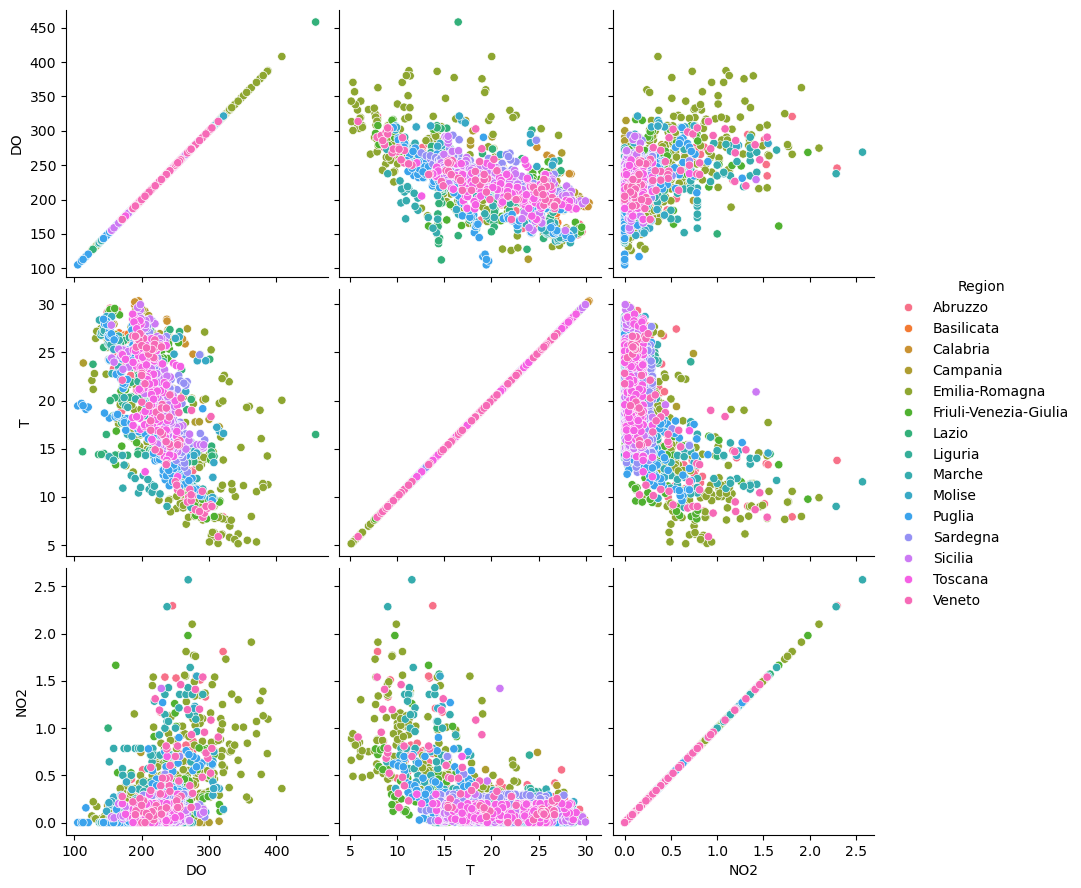

In [39]:
sns.pairplot(
    data=env_long.reset_index().loc[:, ["Region", 'DO', 'T', "NO2"]], 
    x_vars=['DO', 'T', "NO2"],
    diag_kind=None, 
    height=3, 
    hue = "Region"
)

In [ ]:
sns.pairplot(
    data=env_long.loc[:, 'Chla', 'DO', 'NH4', 'NO2', 'NO3', 'O_sat', 'PO4', 'Salinity', 'SiO4', 'T', 'TN', 'TP', 'pH'], 
    y_vars=env_long.columns, 
    x_vars=env_long.columns, 
    diag_kind=None
)